In [38]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import seaborn as sns

Our data is held in a CSV file.  This contains all crimes and officer presence only on weekends.


In [39]:
df = pd.read_csv("weekend_complete.csv")

df.head()

,date,date_new,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
0,26/01/2018,2018-1-26,26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0
1,27/01/2018,2018-1-27,27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1
2,02/02/2018,2018-2-2,2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0
3,03/02/2018,2018-2-3,3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1
4,09/02/2018,2018-2-9,9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0


# Officer Impact on NTE Offences
## Cleaning and Summary Statistics
We begin by importing our data and dependencies, and running some summary statistics.

In [40]:
df["date"] = pd.to_datetime(df["date_new"])
df.index = pd.DatetimeIndex(df["date"]).to_period('D')
weekend_only = df.sort_index()


## Correlation
Let's look for any correlation between our variables.

MSC numbers represents the number of officers we had deployed to our hotspot.

In [41]:
corr = weekend_only.corr()

<AxesSubplot:>

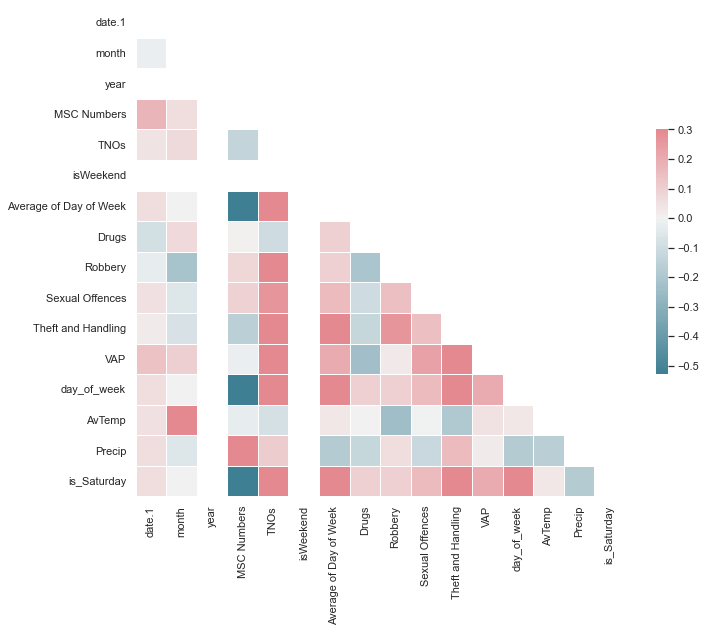

In [42]:
import seaborn as sns


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
corr

,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
date.1,1.000000,-1.849877e-02,NaN,0.176278,0.044201,NaN,5.633013e-02,-0.088697,-0.027534,0.053110,0.024361,0.137165,5.633013e-02,0.048661,0.055915,5.633013e-02
month,-0.018499,1.000000e+00,NaN,0.056914,0.064429,NaN,-3.680038e-17,0.070487,-0.216802,-0.059046,-0.068807,0.102490,-3.680038e-17,0.885969,-0.057926,9.200094e-18
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSC Numbers,0.176278,5.691426e-02,NaN,1.000000,-0.135622,NaN,-5.281401e-01,0.006482,0.082291,0.092611,-0.158839,-0.017405,-5.281401e-01,-0.025138,0.346231,-5.281401e-01
TNOs,0.044201,6.442894e-02,NaN,-0.135622,1.000000,NaN,4.033434e-01,-0.098554,0.332907,0.266886,0.879603,0.636447,4.033434e-01,-0.084617,0.106230,4.033434e-01
isWeekend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average of Day of Week,0.056330,-3.680038e-17,NaN,-0.528140,0.403343,NaN,1.000000e+00,0.095394,0.093161,0.156174,0.367383,0.204583,1.000000e+00,0.030875,-0.180412,1.000000e+00
Drugs,-0.088697,7.048678e-02,NaN,0.006482,-0.098554,NaN,9.539445e-02,1.000000,-0.208351,-0.101804,-0.126924,-0.231236,9.539445e-02,0.002160,-0.125068,9.539445e-02
Robbery,-0.027534,-2.168016e-01,NaN,0.082291,0.332907,NaN,9.316051e-02,-0.208351,1.000000,0.147917,0.261779,0.027145,9.316051e-02,-0.238847,0.058988,9.316051e-02
Sexual Offences,0.053110,-5.904634e-02,NaN,0.092611,0.266886,NaN,1.561738e-01,-0.101804,0.147917,1.000000,0.147703,0.232367,1.561738e-01,-0.002928,-0.116149,1.561738e-01


In [44]:
weekend_only.shape

(54, 18)

In [45]:
weekend_only.head()

,date,date_new,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
date,,,,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,2018-1-26,26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0
2018-01-27,2018-01-27,2018-1-27,27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1
2018-02-02,2018-02-02,2018-2-2,2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0
2018-02-03,2018-02-03,2018-2-3,3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1
2018-02-09,2018-02-09,2018-2-9,9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0


In [46]:
weekend_only.tail()

,date,date_new,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
date,,,,,,,,,,,,,,,,,,
2018-07-14,2018-07-14,2018-7-14,14,7,2018,2,19,1,6,0,1,0,7,8,7,22.55,0.0,1
2018-07-20,2018-07-20,2018-7-20,20,7,2018,9,17,1,5,0,1,1,8,4,6,20.15,0.0,0
2018-07-21,2018-07-21,2018-7-21,21,7,2018,5,4,1,6,1,0,1,1,0,7,23.50,0.0,1
2018-07-27,2018-07-27,2018-7-27,27,7,2018,17,10,1,5,0,0,0,4,4,6,20.60,7.3,0
2018-07-28,2018-07-28,2018-7-28,28,7,2018,7,16,1,6,1,1,0,10,3,7,18.70,0.0,1


In [47]:
saturday_only = weekend_only[weekend_only["is_Saturday"] == 1]
friday_only = weekend_only[weekend_only["is_Saturday"] == 0]

In [48]:
#examining only Saturday
saturday_only.describe()

,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
count,27.000000,27.000000,27.0,27.000000,27.000000,27.0,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.0
mean,16.592593,4.370370,2018.0,3.740741,13.333333,1.0,6.0,0.407407,0.629630,0.259259,7.259259,3.222222,7.0,12.966667,1.062963,1.0
std,9.030969,1.821837,0.0,2.639822,5.896544,0.0,0.0,0.636049,0.629294,0.525693,4.364125,2.154304,0.0,6.671106,1.898410,0.0
min,2.000000,1.000000,2018.0,0.000000,2.000000,1.0,6.0,0.000000,0.000000,0.000000,1.000000,0.000000,7.0,0.000000,0.000000,1.0
25%,9.500000,3.000000,2018.0,1.500000,10.500000,1.0,6.0,0.000000,0.000000,0.000000,3.000000,1.500000,7.0,8.250000,0.000000,1.0
50%,17.000000,4.000000,2018.0,4.000000,12.000000,1.0,6.0,0.000000,1.000000,0.000000,6.000000,3.000000,7.0,13.000000,0.000000,1.0
75%,24.000000,6.000000,2018.0,5.500000,17.000000,1.0,6.0,1.000000,1.000000,0.000000,10.500000,5.000000,7.0,18.850000,1.100000,1.0
max,31.000000,7.000000,2018.0,9.000000,26.000000,1.0,6.0,2.000000,2.000000,2.000000,16.000000,8.000000,7.0,23.500000,7.300000,1.0


In [49]:
#examining only Friday
friday_only.describe()


,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
count,27.000000,27.000000,27.0,27.000000,27.000000,27.0,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.0
mean,15.592593,4.370370,2018.0,7.962963,9.111111,1.0,5.0,0.296296,0.518519,0.111111,4.518519,2.407407,6.0,12.577778,2.274074,0.0
std,9.030969,1.821837,0.0,4.118266,3.587728,0.0,0.0,0.541708,0.579812,0.423659,2.439583,1.802973,0.0,6.147503,4.362744,0.0
min,1.000000,1.000000,2018.0,0.000000,1.000000,1.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.650000,0.000000,0.0
25%,8.500000,3.000000,2018.0,5.500000,7.000000,1.0,5.0,0.000000,0.000000,0.000000,3.000000,1.000000,6.0,7.875000,0.000000,0.0
50%,16.000000,4.000000,2018.0,8.000000,9.000000,1.0,5.0,0.000000,0.000000,0.000000,4.000000,2.000000,6.0,12.000000,0.000000,0.0
75%,23.000000,6.000000,2018.0,9.500000,12.000000,1.0,5.0,0.500000,1.000000,0.000000,6.500000,4.000000,6.0,17.700000,1.850000,0.0
max,30.000000,7.000000,2018.0,18.000000,17.000000,1.0,5.0,2.000000,2.000000,2.000000,9.000000,7.000000,6.0,23.150000,16.900000,0.0


Not entirely surprisingly, we have a correlation between rain and volunteering - this is worth bearing in mind when considering rest of analysis.

The strong negative correlation between Saturdays and officer numbers is concerning, and I am not sure whether this may ruin my analysis.

We now have a dataset of 54 observations, that is configured to a daily frequency

In [50]:
weekend_only["DateClean"] = weekend_only["date"].dt.date
weekend_only["Weekday"] = weekend_only["day_of_week"]
weekend_only["Weekday"] = weekend_only["Weekday"].replace({6:"Friday", 7:"Saturday"})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


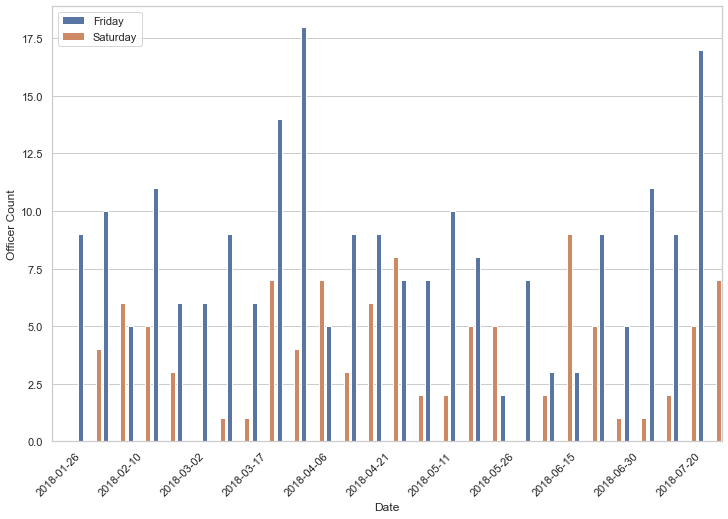

In [51]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(data=weekend_only, x="DateClean", y="MSC Numbers", hue="Weekday", ax=ax)
ax.set(xlabel='Date', ylabel='Officer Count')
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.tick_params(axis='x', labelrotation = 45)

plt.xticks(range(0,weekend_only.shape[0],5))

#plt.legend(loc='upper left', labels=["Friday","Saturday"])
#ax.legend(labels=["Friday","Saturday"])
plt.legend(loc='upper left')

plt.savefig('dosage_by_day.eps', format='eps')
plt.show()

In [52]:
weekend_only.head()

,date,date_new,date.1,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday,DateClean,Weekday
date,,,,,,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,2018-1-26,26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0,2018-01-26,Friday
2018-01-27,2018-01-27,2018-1-27,27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1,2018-01-27,Saturday
2018-02-02,2018-02-02,2018-2-2,2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0,2018-02-02,Friday
2018-02-03,2018-02-03,2018-2-3,3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1,2018-02-03,Saturday
2018-02-09,2018-02-09,2018-2-9,9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0,2018-02-09,Friday


In [53]:
## Descriptive Statistics

In [54]:
weekend_only_crimes = weekend_only[["TNOs","Drugs","Robbery","Theft and Handling","VAP"]]
weekend_only_crimes.describe()

,TNOs,Drugs,Robbery,Theft and Handling,VAP
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,11.222222,0.351852,0.574074,5.888889,2.814815
std,5.283176,0.587846,0.601942,3.765116,2.010107
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,3.000000,1.000000
50%,11.000000,0.000000,1.000000,5.000000,2.000000
75%,13.750000,1.000000,1.000000,8.000000,4.000000
max,26.000000,2.000000,2.000000,16.000000,8.000000


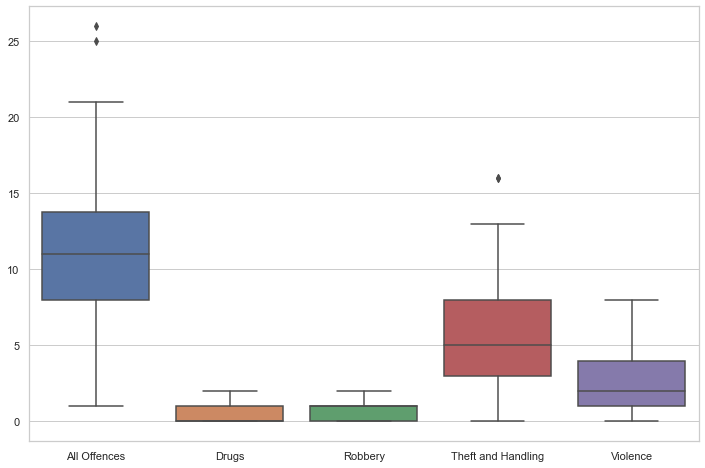

In [55]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.boxplot(data=weekend_only_crimes.rename(columns={"TNOs":"All Offences", "VAP":"Violence"}))
plt.savefig('crime_type_boxplot.eps', format='eps')


In [56]:
column_list = weekend_only.columns
column_list

Index(['date', 'date_new', 'date.1', 'month', 'year', 'MSC Numbers', 'TNOs',
       'isWeekend', 'Average of Day of Week', 'Drugs', 'Robbery',
       'Sexual Offences', 'Theft and Handling', 'VAP', 'day_of_week', 'AvTemp',
       'Precip', 'is_Saturday', 'DateClean', 'Weekday'],
      dtype='object')

As observed, we have a couple of missing observations.
We will start by using OLS regresion, and then compare to an ARIMA time series model
First, we need to analyse our data to settle on ARIMA terms.

P is the AutoRegressive term.
D is the differencing - if we want to remove our seasonable component.  Given we're in a "2 day season", it will be 1.
Q is the moving average.


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

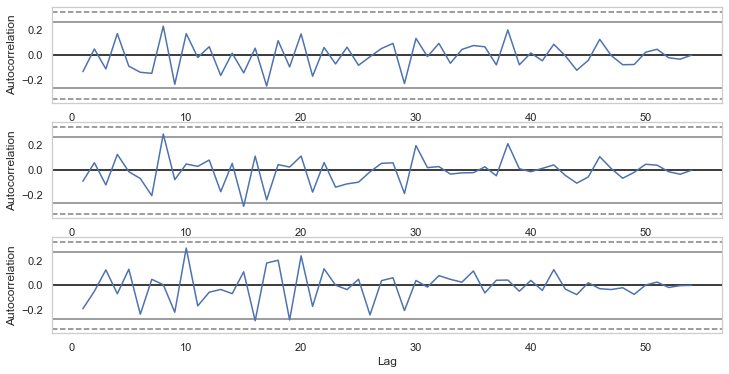

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekend_only["TNOs"], ax=ax1)
autocorrelation_plot(weekend_only["Theft and Handling"], ax=ax2)
autocorrelation_plot(weekend_only["VAP"], ax=ax3)

This suggests our P value will be 0 across all 3.

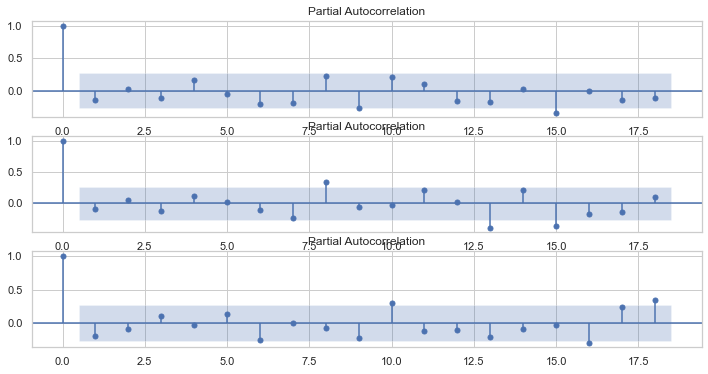

In [58]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_pacf(weekend_only["TNOs"], ax=ax1)
plot_pacf(weekend_only["Theft and Handling"], ax=ax2)
plot_pacf(weekend_only["VAP"], ax=ax3)
plt.show()

This suggests our Q value is 1

For our ARIMA model then, P = 0, D=1, Q=1 (though we will check for fit and tweak as we go along)

# Analysis
## Total Notifiable Offences

Just some descriptive stuff first.

Quick comparison of Friday/Saturday.

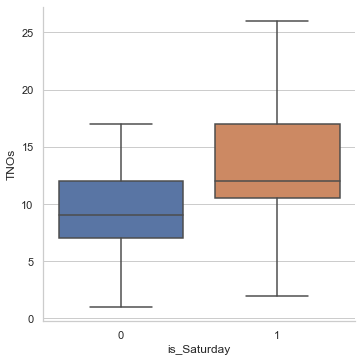

In [59]:
sns.catplot(x="is_Saturday", y="TNOs", kind='box', data=weekend_only.reset_index(drop=True));

Take a look at basic relationship between MSC numbers and TNOs - and also colour by day for an extra bit of perspective.

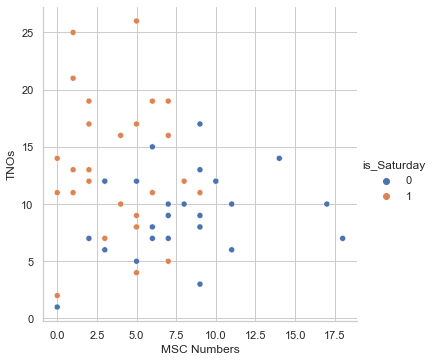

In [60]:
sns.relplot(x="MSC Numbers", y="TNOs", hue="is_Saturday", kind='scatter', data=weekend_only.reset_index(drop=True));

Looks like mainly noise on Saturdays, but possible positive relationship on Saturdays...

Fit a quick bare-bones regression on those.

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Po

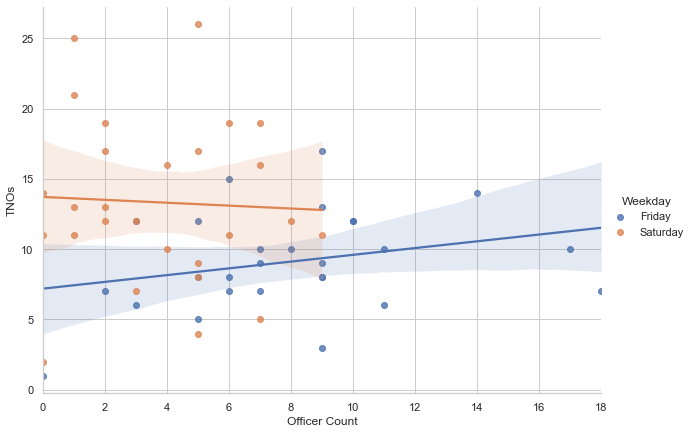

In [61]:
sns.set_style("whitegrid")

sns.lmplot(data=weekend_only.reset_index(drop=True).rename(columns={"MSC Numbers":"Officer Count"}),
           x="Officer Count", y="TNOs", hue="Weekday", size=6, aspect=1.4)

plt.savefig('weekday_relplot.eps', format='eps')
plt.show()

Hmmm - possible interaction between officer effect and day?

### OLS Regression (StatsModels Library)
OLS regression with Saturday, and MSC numbers on crime

In [62]:
X = weekend_only[['MSC Numbers','is_Saturday']]
# y = pd.DataFrame(weekend_only["TNOs"])
y = weekend_only["TNOs"]
# X = sm.add_constant(X.to_numpy())
X = sm.add_constant(X)
#We add a constant to our model (as there is no reason to think when our predictors are 0, crime is also 0)

model = sm.OLS(y, X).fit()
# make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TNOs   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.260
Date:                Fri, 02 Jul 2021   Prob (F-statistic):            0.00838
Time:                        10:42:12   Log-Likelihood:                -160.94
No. Observations:                  54   AIC:                             327.9
Df Residuals:                      51   BIC:                             333.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.9919      1.828      4.372      0.000       4.322      11.662
MSC Numbers     0.1406      0.197      0.715      0.478      -0.254       0.535
is_Saturday     4.8157      1.572      3.064      0.003       1.660       7.971
==============================================================================
Omnibus:                        1.786   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.018
Skew:                           0.277   Prob(JB):                        0.601
Kurtosis:                       3.382   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA (StatsModels Library)

In [63]:
features = ["MSC Numbers", "is_Saturday"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.TNOs   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -159.046
Method:                       css-mle   S.D. of innovations              4.685
Date:                Fri, 02 Jul 2021   AIC                            328.092
Time:                        10:42:20   BIC                            337.944
Sample:                    01-27-2018   HQIC                           331.881
                         - 07-28-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.9462      1.454     -2.026      0.043      -5.796      -0.096
MSC Numbers     -0.1522      0.086     -1.774      0.076      -0.320       0.016
is_Saturday      7.7380      2.579      3.001      0.003       2.684      12.792
ma.L1.D.TNOs    -1.0000      0.060    -16.708      0.000      -1.117      -0.883
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Now, with temp included - our optimal model.

In [64]:
features = ["MSC Numbers","AvTemp", "is_Saturday"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.TNOs   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -157.987
Method:                       css-mle   S.D. of innovations              4.593
Date:                Fri, 02 Jul 2021   AIC                            327.974
Time:                        10:42:22   BIC                            339.796
Sample:                    01-27-2018   HQIC                           332.520
                         - 07-28-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0516      1.550     -1.324      0.186      -5.089       0.985
MSC Numbers     -0.2257      0.098     -2.307      0.021      -0.417      -0.034
AvTemp          -0.0238      0.016     -1.470      0.142      -0.056       0.008
is_Saturday      7.4263      2.536      2.928      0.003       2.455      12.397
ma.L1.D.TNOs    -0.9997      0.051    -19.612      0.000      -1.100      -0.900
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

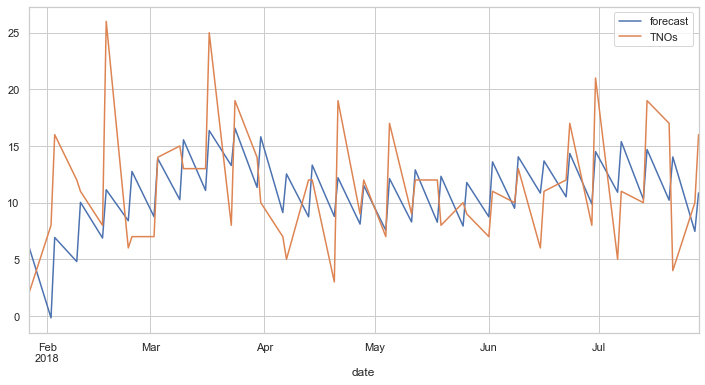

In [65]:
model_fit.plot_predict();


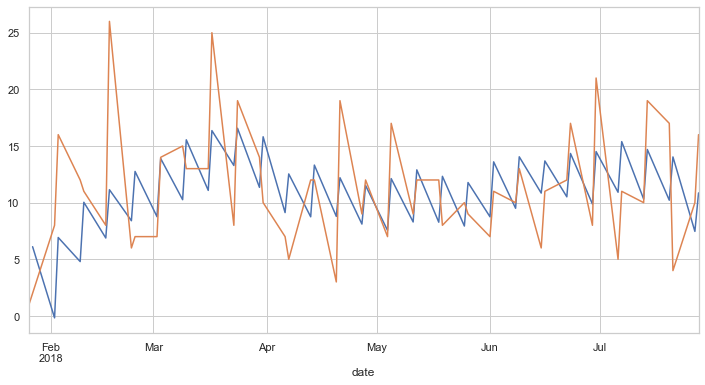

In [66]:
model_fit.predict(typ='levels').plot()
weekend_only["TNOs"].plot();

In [67]:
weekend_only["Predicted TNOs"] = model_fit.predict(typ='levels')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


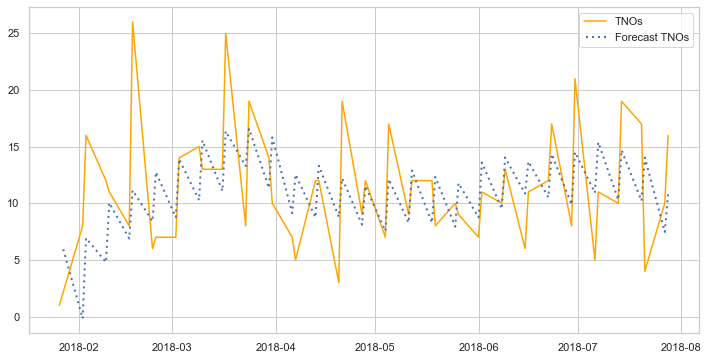

In [76]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(weekend_only["date"],
        weekend_only["TNOs"], label="TNOs", color="orange")

ax.plot(weekend_only["date"], weekend_only["Predicted TNOs"],
        label="Forecast TNOs",
        dashes=[0,1,1,1],
        linewidth=2)

plt.legend()
plt.savefig('model_forecast.eps', format='eps')



Just to make sure, these are the residuals one gets from that - thankfully they match what comes later.

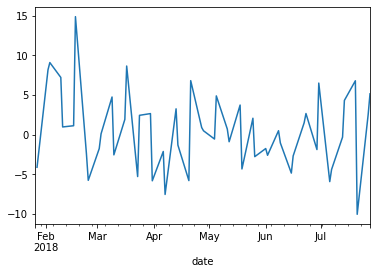

In [27]:
(weekend_only["TNOs"] - model_fit.predict(typ='levels')).plot();

Our RMSE

In [28]:
predictions = model_fit.predict(typ='levels')
mse = mean_squared_error(weekend_only["TNOs"].iloc[1:], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:23.366415772090274
RMSE:4.833882060217261


Examining our residuals and their distribution

<AxesSubplot:xlabel='date'>

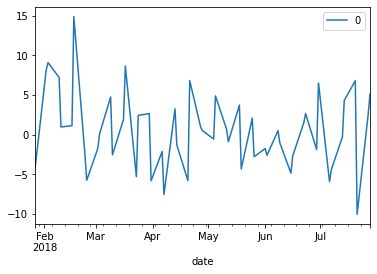

In [29]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

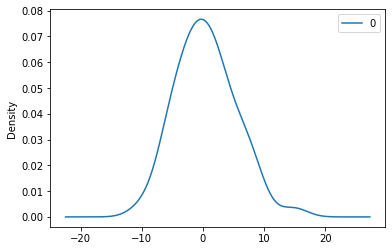

In [30]:
residuals.plot(kind="kde")

### Auto-ARIMA Model


In [31]:
features = ["MSC Numbers", "AvTemp", "is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -160.082
Date:                Fri, 02 Jul 2021   AIC                            330.165
Time:                        07:39:35   BIC                            340.016
Sample:                    01-26-2018   HQIC                           333.953
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers     0.0925      0.262      0.353      0.724      -0.421       0.605
AvTemp         -0.2783      0.176     -1.582      0.114      -0.623       0.067
is_Saturday     4.6247      1.788      2.586      0.010       1.120       8.130
ma.L1          -0.8850      0.082    -10.767      0.000      -1.046      -0.724
sigma2         23.9058      4.680      5.108      0.000      14.733      33.079
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.73   Prob(JB):                         0.83
Heteroskedasticity (H):               0.57   Skew:                             0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
predictions = auto.predict(n_periods=weekend_only.shape[0], exogenous=weekend_only[features])

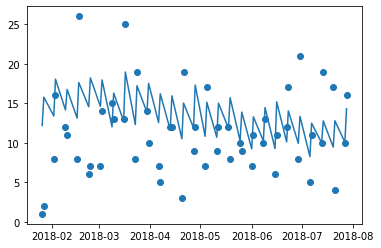

In [33]:
plt.plot(weekend_only["date"], predictions)
plt.scatter(weekend_only["date"], weekend_only["TNOs"])

Also concerned by this - the model output seems clearly well out-of-step with the data. Turns out that the `predict()` method is for out-of-sample prediction (i.e. forecasting) - there is a special method for in-sample:

In [34]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])

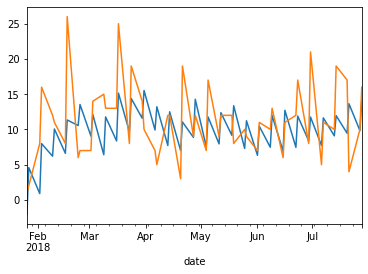

In [35]:
predictions.plot()
weekend_only["TNOs"].plot();

Much better...

In [36]:
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))


Mean Squared Error:24.457131801316844
RMSE:4.945415230424726


### Quick look at some diagnostics

Here.

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\pmdarima\utils\visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


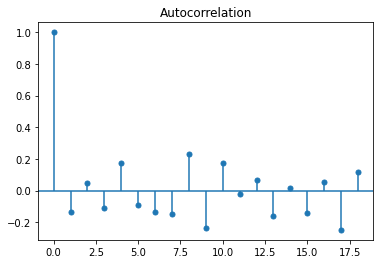

In [37]:
pm.plot_acf(weekend_only["TNOs"])

In [38]:
from pmdarima.arima.utils import ndiffs, nsdiffs

print(ndiffs(weekend_only["TNOs"], test='adf'))

1


In [39]:
nsdiffs(weekend_only["TNOs"],
        m=2,
        max_D=12,
        test='ch')

0

Try an explicitly seasonal model here - set `seasonal=True` with period equal to 2:

In [40]:
weekend_only["MSC Numbers_x_is_Saturday"] = weekend_only["MSC Numbers"] * weekend_only["is_Saturday"]
features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
# features = ["MSC Numbers", "AvTemp", "is_Saturday"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, m=2, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -159.771
Date:                Fri, 02 Jul 2021   AIC                            331.542
Time:                        07:40:06   BIC                            343.364
Sample:                    01-26-2018   HQIC                           336.088
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MSC Numbers                   0.1889      0.357      0.529      0.597      -0.511       0.889
AvTemp                       -0.2742      0.187     -1.464      0.143      -0.641       0.093
is_Saturday                   6.2465      3.807      1.641      0.101      -1.215      13.708
MSC Numbers_x_is_Saturday    -0.3244      0.554     -0.586      0.558      -1.410       0.761
ma.L1                        -0.8884      0.088    -10.123      0.000      -1.060      -0.716
sigma2                       23.6138      4.745      4.977      0.000      14.315      32.913
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.75   Prob(JB):                         0.74
Heteroskedasticity (H):               0.53   Skew:                             0.26
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])

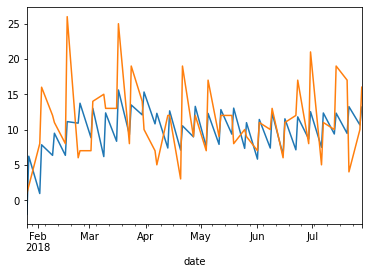

In [42]:
predictions.plot()
weekend_only["TNOs"].plot();

In [43]:
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:24.289102375184864
RMSE:4.928397546382076


ANDREAS - replicating with only Saturday data

In [44]:
saturday_only = weekend_only[weekend_only["is_Saturday"] == 1]

# features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
features = ["MSC Numbers", "AvTemp"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(saturday_only["TNOs"],exogenous=saturday_only[features], stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   27
Model:                        SARIMAX   Log Likelihood                 -85.282
Date:                Fri, 02 Jul 2021   AIC                            178.563
Time:                        07:40:21   BIC                            183.747
Sample:                    01-27-2018   HQIC                           180.105
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      15.6526      2.471      6.336      0.000      10.810      20.495
MSC Numbers    -0.0974      0.461     -0.211      0.833      -1.000       0.805
AvTemp         -0.1508      0.158     -0.954      0.340      -0.460       0.159
sigma2         32.4364     10.689      3.035      0.002      11.487      53.386
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.40   Prob(JB):                         0.85
Heteroskedasticity (H):               0.47   Skew:                             0.11
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
predictions = auto.predict_in_sample(exogenous=saturday_only[features])

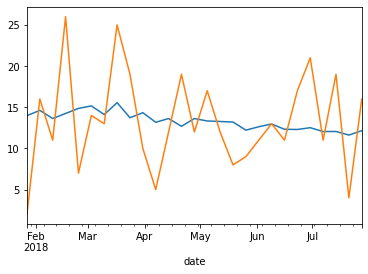

In [46]:
predictions.plot()
saturday_only["TNOs"].plot();

In [47]:
mse = mean_squared_error(saturday_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:32.436509541779365
RMSE:5.695305921702483


ANDREAS - ..and now only Friday

In [48]:
saturday_only = weekend_only[weekend_only["is_Saturday"] == 0]

# features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
features = ["MSC Numbers", "AvTemp"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(saturday_only["TNOs"],exogenous=saturday_only[features], stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   27
Model:                        SARIMAX   Log Likelihood                 -71.221
Date:                Fri, 02 Jul 2021   AIC                            150.443
Time:                        07:40:27   BIC                            155.626
Sample:                    01-26-2018   HQIC                           151.984
                         - 07-27-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       7.1054      1.934      3.673      0.000       3.314      10.897
MSC Numbers     0.2409      0.146      1.654      0.098      -0.045       0.526
AvTemp          0.0070      0.119      0.058      0.953      -0.226       0.240
sigma2         11.4474      3.555      3.220      0.001       4.479      18.416
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.36   Prob(JB):                         0.87
Heteroskedasticity (H):               0.82   Skew:                             0.21
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
predictions = auto.predict_in_sample(exogenous=saturday_only[features])

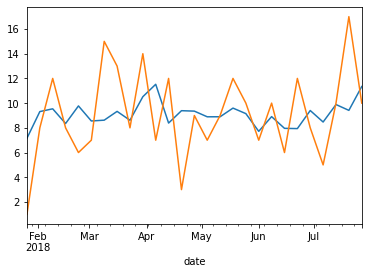

In [50]:
predictions.plot()
saturday_only["TNOs"].plot();

In [51]:
mse = mean_squared_error(saturday_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:11.44758838305843
RMSE:3.383428495337005



## Theft Offences

### OLS Regression
OLS regression with Saturday, and MSC numbers on crime

In [52]:
X = weekend_only[['is_Saturday','MSC Numbers']]
y = pd.DataFrame(weekend_only["Theft and Handling"])
X = sm.add_constant(X.to_numpy())

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Theft and Handling   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     4.037
Date:                Fri, 02 Jul 2021   Prob (F-statistic):             0.0236
Time:                        07:40:28   Log-Likelihood:                -143.74
No. Observations:                  54   AIC:                             293.5
Df Residuals:                      51   BIC:                             299.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1559      1.329      3.126      0.003       1.487       6.825
x1             2.9330      1.143      2.566      0.013       0.638       5.228
x2             0.0455      0.143      0.319      0.751      -0.241       0.333
==============================================================================
Omnibus:                        1.569   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.453
Skew:                           0.386   Prob(JB):                        0.484
Kurtosis:                       2.778   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA
Again, adding temperature barely effects our AIC, and is not significant

In [53]:
features = ['MSC Numbers', "is_Saturday"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["Theft and Handling"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.Theft and Handling   No. Observations:                   53
Model:                   ARIMA(0, 1, 1)   Log Likelihood                -141.784
Method:                         css-mle   S.D. of innovations              3.383
Date:                  Fri, 02 Jul 2021   AIC                            293.568
Time:                          07:40:30   BIC                            303.419
Sample:                      01-27-2018   HQIC                           297.356
                           - 07-28-2018                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8345      1.050     -1.747      0.081      -3.892       0.223
MSC Numbers                   -0.1159      0.062     -1.872      0.061      -0.237       0.005
is_Saturday                    5.0081      1.862      2.690      0.007       1.359       8.657
ma.L1.D.Theft and Handling    -0.9997      0.055    -18.323      0.000      -1.107      -0.893
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

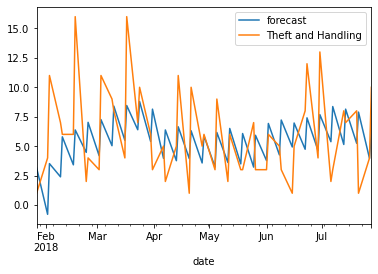

In [54]:
model_fit.plot_predict(exog=weekend_only[features])
plt.show()

### Auto-ARIMA Model


In [55]:
features = ["MSC Numbers", "AvTemp", "is_Saturday"]

auto = pm.auto_arima(weekend_only["Theft and Handling"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -147.118
Date:                Fri, 02 Jul 2021   AIC                            306.236
Time:                        07:40:48   BIC                            318.058
Sample:                    01-26-2018   HQIC                           310.782
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0198      0.181     -0.109      0.913      -0.375       0.336
AvTemp         -0.2909      0.157     -1.849      0.065      -0.599       0.018
is_Saturday     2.6632      1.076      2.474      0.013       0.554       4.773
ar.L1          -0.5972      0.132     -4.509      0.000      -0.857      -0.338
ar.L2          -0.3315      0.164     -2.025      0.043      -0.652      -0.011
sigma2         14.9562      3.745      3.994      0.000       7.617      22.296
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.61   Prob(JB):                         0.53
Heteroskedasticity (H):               0.76   Skew:                            -0.03
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
weekend_only["MSC Numbers_x_is_Saturday"] = weekend_only["MSC Numbers"] * weekend_only["is_Saturday"]
features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
# features = ["MSC Numbers", "AvTemp", "is_Saturday"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(weekend_only["Theft and Handling"],exogenous=weekend_only[features], d=1, seasonal=True, m=2, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 2)   Log Likelihood                -137.873
Date:                           Fri, 02 Jul 2021   AIC                            295.746
Time:                                   07:41:14   BIC                            315.449
Sample:                               01-26-2018   HQIC                           303.323
                                    - 07-28-2018                                         
Covariance Type:                             opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.0439      0.045      0.984      0.325      -0.044       0.131
MSC Numbers                   0.0341      0.333      0.102      0.918      -0.618       0.686
AvTemp                       -0.4638      0.152     -3.046      0.002      -0.762      -0.165
is_Saturday                   3.9223      2.805      1.399      0.162      -1.575       9.419
MSC Numbers_x_is_Saturday    -0.2820      0.452     -0.624      0.532      -1.167       0.603
ar.L1                         0.0389      0.195      0.199      0.842      -0.343       0.421
ma.L1                        -0.9840      0.789     -1.247      0.212      -2.531       0.563
ar.S.L2                       0.6857      0.283      2.427      0.015       0.132       1.239
ma.S.L2                      -0.9782      0.976     -1.002      0.316      -2.891       0.935
sigma2                        9.1674     11.423      0.803      0.422     -13.221      31.556
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.89   Prob(JB):                         0.71
Heteroskedasticity (H):               0.66   Skew:                             0.12
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Violence

### OLS Regression
OLS regression with Saturday, MSC Numbers, and Temperature on crime

In [57]:
X = weekend_only[['is_Saturday','MSC Numbers','AvTemp']]
y = pd.DataFrame(weekend_only["VAP"])
X = sm.add_constant(X.to_numpy())

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    VAP   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9664
Date:                Fri, 02 Jul 2021   Prob (F-statistic):              0.416
Time:                        07:41:14   Log-Likelihood:                -112.30
No. Observations:                  54   AIC:                             232.6
Df Residuals:                      50   BIC:                             240.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7499      0.932      1.877      0.066      -0.123       3.622
x1             1.0754      0.645      1.667      0.102      -0.220       2.371
x2             0.0629      0.081      0.779      0.439      -0.099       0.225
x3             0.0125      0.043      0.287      0.775      -0.075       0.100
==============================================================================
Omnibus:                        2.783   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.658
Skew:                           0.520   Prob(JB):                        0.265
Kurtosis:                       2.681   Cond. No.                         57.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA

In [58]:
features = ['MSC Numbers', "AvTemp", "is_Saturday"]
# 0,0,1 ARIMA model
model = ARIMA(weekend_only["VAP"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.VAP   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -111.373
Method:                       css-mle   S.D. of innovations              1.906
Date:                Fri, 02 Jul 2021   AIC                            234.745
Time:                        07:41:15   BIC                            246.567
Sample:                    01-27-2018   HQIC                           239.291
                         - 07-28-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1987      0.643     -0.309      0.757      -1.459       1.062
MSC Numbers    -0.0575      0.041     -1.418      0.156      -0.137       0.022
AvTemp         -0.0095      0.007     -1.420      0.156      -0.023       0.004
is_Saturday     1.3525      1.053      1.285      0.199      -0.710       3.415
ma.L1.D.VAP    -1.0000      0.051    -19.758      0.000      -1.099      -0.901
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

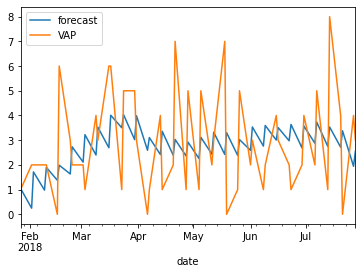

In [59]:
model_fit.plot_predict(exog=weekend_only[features])
plt.show()

### Auto-ARIMA Model


In [60]:
features = ["MSC Numbers", "AvTemp", "is_Saturday"]

auto = pm.auto_arima(weekend_only["VAP"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -116.173
Date:                Fri, 02 Jul 2021   AIC                            244.345
Time:                        07:41:28   BIC                            256.167
Sample:                    01-26-2018   HQIC                           248.891
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers     0.0145      0.087      0.167      0.868      -0.156       0.185
AvTemp         -0.0107      0.107     -0.100      0.920      -0.221       0.199
is_Saturday     0.9146      0.590      1.550      0.121      -0.242       2.071
ar.L1          -0.7972      0.160     -4.971      0.000      -1.112      -0.483
ar.L2          -0.5146      0.126     -4.089      0.000      -0.761      -0.268
sigma2          4.6102      1.082      4.262      0.000       2.490       6.730
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.48   Prob(JB):                         0.81
Heteroskedasticity (H):               1.10   Skew:                             0.06
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
weekend_only["MSC Numbers_x_is_Saturday"] = weekend_only["MSC Numbers"] * weekend_only["is_Saturday"]
features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
# features = ["MSC Numbers", "AvTemp", "is_Saturday"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(weekend_only["VAP"],exogenous=weekend_only[features], d=1, seasonal=True, m=2, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   54
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 2)   Log Likelihood                -119.503
Date:                           Fri, 02 Jul 2021   AIC                            253.006
Time:                                   07:41:42   BIC                            266.798
Sample:                               01-26-2018   HQIC                           258.309
                                    - 07-28-2018                                         
Covariance Type:                             opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MSC Numbers                   0.0785      0.135      0.581      0.561      -0.186       0.343
AvTemp                        0.0045      0.121      0.037      0.970      -0.233       0.242
is_Saturday                   1.2830      1.509      0.850      0.395      -1.675       4.241
MSC Numbers_x_is_Saturday    -0.0606      0.214     -0.283      0.777      -0.480       0.359
ar.L1                        -0.6756      0.174     -3.878      0.000      -1.017      -0.334
ar.S.L2                      -0.4327      0.239     -1.808      0.071      -0.902       0.036
sigma2                        5.2546      1.109      4.739      0.000       3.081       7.428
===================================================================================
Ljung-Box (L1) (Q):                   5.82   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.02   Prob(JB):                         0.96
Heteroskedasticity (H):               1.21   Skew:                             0.06
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""